In [7]:
from google.colab import drive

In [2]:
import pandas as pd
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

In [8]:
# load the data
df = pd.read_csv("/content/chicken_egg.csv")
df.head()

,chicken,egg
0,468491,3581
1,449743,3532
2,436815,3327
3,444523,3255
4,433937,3156


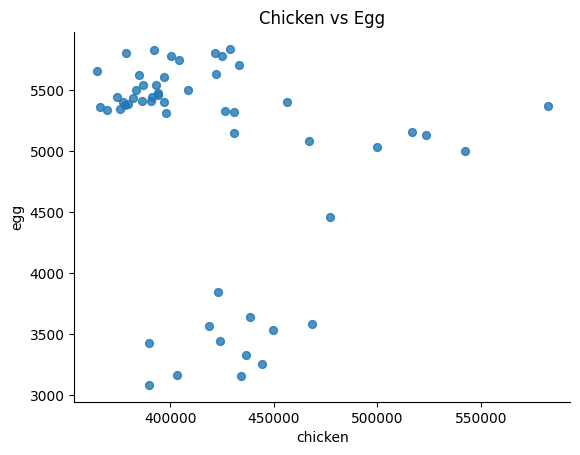

In [10]:
# @title chicken vs egg

from matplotlib import pyplot as plt
df.plot(kind='scatter', x='chicken', y='egg', s=32, alpha=.8, title = 'Chicken vs Egg')
plt.gca().spines[['top', 'right',]].set_visible(False)

Data Processing

In [11]:
# isolate chicken and eggs
chicken = df['chicken']
egg = df['egg']
egg.head()

,egg
0,3581
1,3532
2,3327
3,3255
4,3156


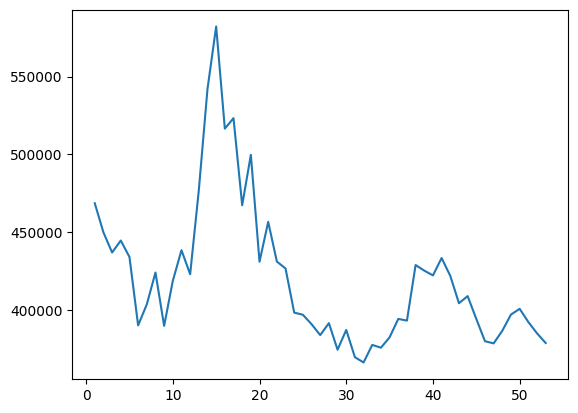

In [15]:
# visualize eggs against chicken lagged 1 period
chicken_lag = chicken.shift(1)
chicken_lag.plot()
plt.show()

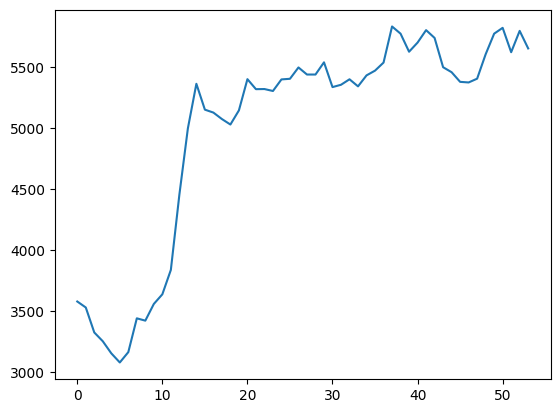

In [16]:
# visualize x
egg.plot()
plt.show()

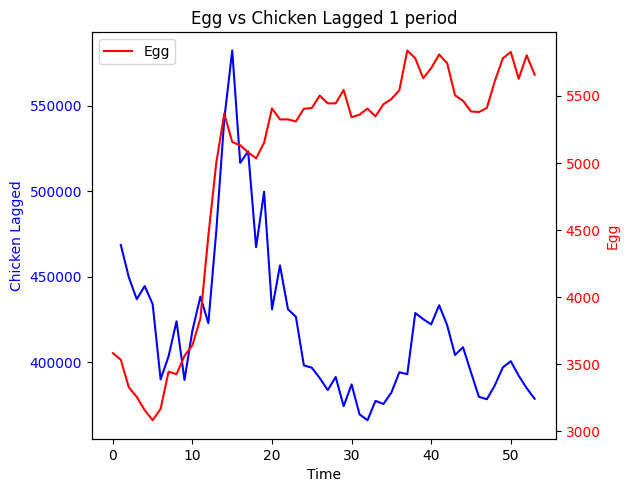

In [17]:
fig, ax1 = plt.subplots()
ax1.plot(chicken_lag, label='Chicken lagged', color='blue')
ax1.set_xlabel('Time')
ax1.set_ylabel('Chicken Lagged', color='blue')
ax1.tick_params('y',labelcolor='blue')

ax2=ax1.twinx()
ax2.plot(egg, label='Egg', color='red')
ax2.set_ylabel('Egg', color='red')
ax2.tick_params('y',labelcolor='red')

fig.tight_layout() # adjust layout to prevent overlapping labels
plt.title('Egg vs Chicken Lagged 1 period')
plt.legend()
plt.show()


In [18]:
# stationary analysis -Dickey fuller test
result_egg = adfuller(egg)
result_chicken = adfuller(chicken)
print(f"The p-value for egg is {result_egg[1]}")
print(f"The p-value for chicken is {result_chicken[1]}")
# p is larger than 0.05 so it is not stationary, failed to reject H0 not stationary

The p-value for egg is 0.4231858463747657
The p-value for chicken is 0.3004953142442696


In [20]:
# interpret the p-value
def interpret(p_value):
  if p_value > 0.05:
    print("The data is not stationary")
  else:
    print("The data is stationary")
interpret(result_egg[1])
interpret(result_chicken[1])

The data is not stationary
The data is not stationary


In [27]:
# Apply differencing to make egg and chicken stationary
# calculate the difference from prior value and drop the first NA
degg = egg.diff().dropna()
dchicken = chicken.diff().dropna()

In [23]:
result_degg = adfuller(deggs)
result_dchicken = adfuller(dchicken)
interpret(result_degg[1])
interpret(result_dchicken[1])

The data is stationary
The data is stationary


Granger social media causality
egg leads to chicken
chicken leads to egg. causality happens when the outcome is statistically significant for one test but not the other for the same lag

In [56]:
df_chicken_to_egg = pd.concat([ degg, dchicken], axis=1)
df_chicken_to_egg.columns = [ 'degg','dchicken']
df_chicken_to_egg.head()

,degg,dchicken
1,-49.0,-18748.0
2,-205.0,-12928.0
3,-72.0,7708.0
4,-99.0,-10586.0
5,-75.0,-43979.0


In [57]:
df_egg_to_chicken = pd.concat([dchicken, degg], axis=1)
df_egg_to_chicken.columns = ['dchicken','degg']
df_egg_to_chicken.head()

,dchicken,degg
1,-18748.0,-49.0
2,-12928.0,-205.0
3,7708.0,-72.0
4,-10586.0,-99.0
5,-43979.0,-75.0


In [58]:
# grainger causality: chicken to egg
impact_chicken_to_egg = grangercausalitytests(df_chicken_to_egg, maxlag=15)
impact_egg_to_chicken = grangercausalitytests(df_egg_to_chicken, maxlag=15)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5434  , p=0.4646  , df_denom=49, df_num=1
ssr based chi2 test:   chi2=0.5766  , p=0.4476  , df=1
likelihood ratio test: chi2=0.5734  , p=0.4489  , df=1
parameter F test:         F=0.5434  , p=0.4646  , df_denom=49, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3865  , p=0.6816  , df_denom=46, df_num=2
ssr based chi2 test:   chi2=0.8571  , p=0.6515  , df=2
likelihood ratio test: chi2=0.8500  , p=0.6538  , df=2
parameter F test:         F=0.3865  , p=0.6816  , df_denom=46, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2245  , p=0.8788  , df_denom=43, df_num=3
ssr based chi2 test:   chi2=0.7833  , p=0.8535  , df=3
likelihood ratio test: chi2=0.7772  , p=0.8549  , df=3
parameter F test:         F=0.2245  , p=0.8788  , df_denom=43, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.2817  , p=0.8881  , df_d

In [59]:
print(impact_chicken_to_egg[1][0]['ssr_ftest'])

(np.float64(0.5433559398877654), np.float64(0.46456032713253714), np.float64(49.0), np.int64(1))


In [60]:
print(impact_egg_to_chicken[1][0]['ssr_ftest'])

(np.float64(10.36940185502431), np.float64(0.0022765477808029005), np.float64(49.0), np.int64(1))


In [62]:
# Function to extract grainger causality
def extract_results(result):
  test_results = []
  for lag, res in result.items():
    p_value = res[0]['ssr_ftest'][1]
    test_results.append((lag, p_value))
  return pd.DataFrame(test_results, columns=['lag', 'p_value'])


In [63]:
# apply the function to create df
case_df_chicken_to_egg = extract_results(impact_chicken_to_egg)
case_df_egg_to_chicken = extract_results(impact_egg_to_chicken)

In [64]:
case_df_egg_to_chicken

,lag,p_value
0,1,0.002277
1,2,0.026802
2,3,0.044129
3,4,0.006414
4,5,0.020783
5,6,0.030342
6,7,0.080712
7,8,0.050853
8,9,0.104019
9,10,0.051296


In [65]:
case_df_chicken_to_egg

,lag,p_value
0,1,0.464560
1,2,0.681595
2,3,0.878808
3,4,0.888125
4,5,0.898937
5,6,0.929459
6,7,0.888652
7,8,0.954615
8,9,0.963825
9,10,0.593479


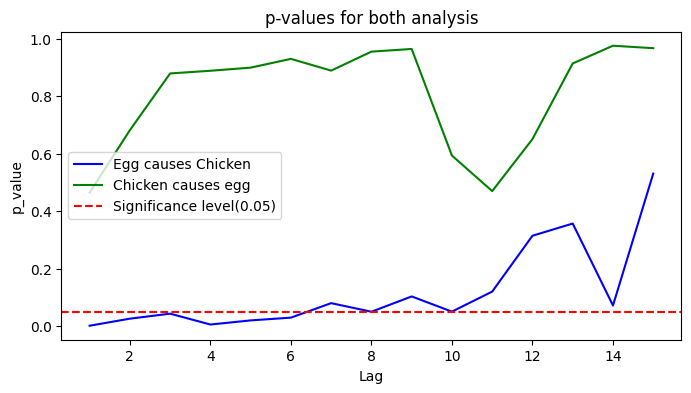

In [69]:
# Visualize the p-values for both analysis
plt.figure(figsize=(8,4))
plt.plot(case_df_egg_to_chicken['lag']
         , case_df_egg_to_chicken['p_value']
         , color = 'blue'
         , label='Egg causes Chicken')
plt.plot(case_df_chicken_to_egg['lag']
         ,case_df_chicken_to_egg['p_value']
         ,color='green'
         , label='Chicken causes egg')
plt.axhline(y=0.05, color='red', linestyle='--', label = 'Significance level(0.05)')
plt.legend()
plt.title('p-values for both analysis')
plt.xlabel('Lag')
plt.ylabel('p_value')
plt.show()


*  From year 1-6, there is evidence that eggs lead to chicken
*  From year 7-10, the evidence exists but it is weak that eggs lead to chicken
*  There is no eidence to support that eggs lead to chicken after year 10 or chicken lead to eggs



